In [1]:
import statsmodels.api as sm
import statsmodels.stats.sandwich_covariance as sw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [2]:
KO = pd.read_excel(
    "data/KO.xlsx",
    sheet_name=0,
    engine="openpyxl"
)

KO["Date"] = pd.to_datetime(KO["Date"])
KO = KO.set_index("Date").sort_index()

KO.head()

,Close
Date,
2020-01-02,54.99
2020-01-03,54.69
2020-01-06,54.67
2020-01-07,54.25
2020-01-08,54.35


In [3]:
SPY = pd.read_excel(
    "data/SPY.xlsx",
    sheet_name=0,
    engine="openpyxl"
)

SPY["Date"] = pd.to_datetime(SPY["Date"])
SPY = SPY.set_index("Date").sort_index()

SPY.head()

,Close
Date,
2020-01-02,324.87
2020-01-03,322.41
2020-01-06,323.64
2020-01-07,322.73
2020-01-08,324.45


In [4]:
GCF = pd.read_excel(
    "data/GCF.xlsx",
    sheet_name=0,
    engine="openpyxl"
)

GCF["Date"] = pd.to_datetime(GCF["Date"])
GCF = GCF.set_index("Date").sort_index()

GCF.head()

,Close
Date,
2020-01-02,1524.5
2020-01-03,1549.2
2020-01-06,1566.2
2020-01-07,1571.8
2020-01-08,1557.4


In [5]:
CRSP = pd.read_excel(
    "data/CRSP.xlsx",
    sheet_name=0,
    engine="openpyxl"
)

CRSP["Date"] = pd.to_datetime(CRSP["Date"])
CRSP = CRSP.set_index("Date").sort_index()

CRSP.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2020-01-02,0.86,-0.88,-0.34,0.006
2020-01-03,-0.67,0.38,0.01,0.006
2020-01-06,0.36,-0.07,-0.55,0.006
2020-01-07,-0.19,-0.01,-0.26,0.006
2020-01-08,0.47,-0.07,-0.64,0.006


## Calculate daily rate of return

In [6]:
# r(t+1) = ln[P(t+1) / P(t)]
KO["log_return"] = np.log(KO["Close"] / KO["Close"].shift(1))

# r(t+1) = [P(t+1) - P(t)] / P(t)
KO["arith_return"] = KO["Close"].pct_change()

KO.head()

,Close,log_return,arith_return
Date,,,
2020-01-02,54.99,NaN,NaN
2020-01-03,54.69,-0.005470,-0.005456
2020-01-06,54.67,-0.000366,-0.000366
2020-01-07,54.25,-0.007712,-0.007682
2020-01-08,54.35,0.001842,0.001843


In [7]:
# r(t+1) = ln[P(t+1) / P(t)]
SPY["log_return"] = np.log(SPY["Close"] / SPY["Close"].shift(1))

# r(t+1) = [P(t+1) - P(t)] / P(t)
SPY["arith_return"] = SPY["Close"].pct_change()

SPY.head()

,Close,log_return,arith_return
Date,,,
2020-01-02,324.87,NaN,NaN
2020-01-03,322.41,-0.007601,-0.007572
2020-01-06,323.64,0.003808,0.003815
2020-01-07,322.73,-0.002816,-0.002812
2020-01-08,324.45,0.005315,0.005330


In [8]:
# r(t+1) = ln[P(t+1) / P(t)]
GCF["log_return"] = np.log(GCF["Close"] / GCF["Close"].shift(1))

# r(t+1) = [P(t+1) - P(t)] / P(t)
GCF["arith_return"] = GCF["Close"].pct_change()

GCF.head()

,Close,log_return,arith_return
Date,,,
2020-01-02,1524.5,NaN,NaN
2020-01-03,1549.2,0.016072,0.016202
2020-01-06,1566.2,0.010914,0.010973
2020-01-07,1571.8,0.003569,0.003576
2020-01-08,1557.4,-0.009204,-0.009161


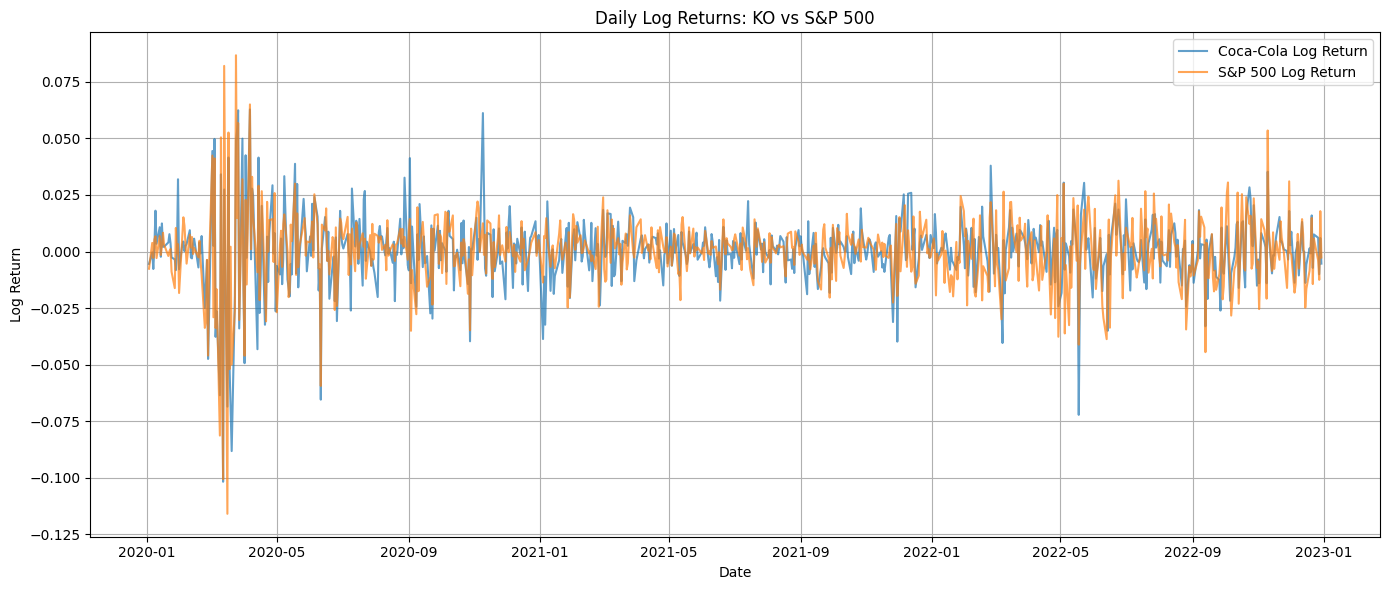

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(KO.index, KO["log_return"], label='Coca-Cola Log Return', alpha=0.7)
plt.plot(SPY.index, SPY["log_return"], label='S&P 500 Log Return', alpha=0.7)
plt.title("Daily Log Returns: KO vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/KO_vs_SPY_log_return.png", dpi=300)
plt.show()


## Stock data

In [10]:
# 选用对数收益率列并去掉 NaN
KO_ret = KO["log_return"].dropna()

# 计算统计量
stats = {
    "Name"       : "Coca-Cola",
    "Ticker"     : "KO",
    "Mean"       : KO_ret.mean(),
    "Median"     : KO_ret.median(),
    "Std Dev"    : KO_ret.std(ddof=1),   # 样本标准差
    "Min"        : KO_ret.min(),
    "Max"        : KO_ret.max(),
    "Skewness"   : KO_ret.skew(),
    "Kurtosis"   : KO_ret.kurt(),
    "Start Date" : KO_ret.index.min().date(),
    "End Date"   : KO_ret.index.max().date()
}


summary = pd.DataFrame(stats, index=["Value"]).T
print(summary.to_string())

                 Value
Name         Coca-Cola
Ticker              KO
Mean          0.000193
Median        0.000958
Std Dev       0.015624
Min          -0.101728
Max           0.062783
Skewness     -0.841427
Kurtosis      6.966093
Start Date  2020-01-03
End Date    2022-12-30


In [11]:
# 选用对数收益率列并去掉 NaN
SPY_ret = SPY["log_return"].dropna()

# 计算统计量
stats = {
    "Name"       : "SPDR S&P 500 ETF",
    "Ticker"     : "SPY",
    "Mean"       : SPY_ret.mean(),
    "Median"     : SPY_ret.median(),
    "Std Dev"    : SPY_ret.std(ddof=1),   # 样本标准差
    "Min"        : SPY_ret.min(),
    "Max"        : SPY_ret.max(),
    "Skewness"   : SPY_ret.skew(),
    "Kurtosis"   : SPY_ret.kurt(),
    "Start Date" : SPY_ret.index.min().date(),
    "End Date"   : SPY_ret.index.max().date()
}

summary = pd.DataFrame(stats, index=["Value"]).T
print(summary.to_string())

                       Value
Name        SPDR S&P 500 ETF
Ticker                   SPY
Mean                0.000216
Median              0.000853
Std Dev             0.015876
Min                -0.115887
Max                 0.086731
Skewness           -0.736754
Kurtosis            9.408741
Start Date        2020-01-03
End Date          2022-12-30


## Separate the data

In [12]:
# --- 函数：计算描述性统计 -------------------------------------------------
def get_stats(series):
    return {
        "Mean"     : series.mean(),
        "Median"   : series.median(),
        "Std Dev"  : series.std(ddof=1),
        "Min"      : series.min(),
        "Max"      : series.max(),
        "Skewness" : series.skew(),
        "Kurtosis" : series.kurt()
    }

# --- 1. 按时间切片 --------------------------------------------------------
train_KO = KO.loc["2020":"2021", "log_return"].dropna()   # 前两年
test_KO  = KO.loc["2022", "log_return"].dropna() # 最后一年

# --- 2. 生成统计表 ---------------------------------------------------------
stats_train_KO = pd.DataFrame(get_stats(train_KO), index=["2020-2021"]).T
stats_test_KO  = pd.DataFrame(get_stats(test_KO),  index=["2022"]).T

print("\n===== KO-train (2020-2021) =====")
print(stats_train_KO.to_string())

print("\n===== KO-test (2022) =====")
print(stats_test_KO.to_string())


===== KO-train (2020-2021) =====
          2020-2021
Mean       0.000147
Median     0.000751
Std Dev    0.016984
Min       -0.101728
Max        0.062783
Skewness  -0.815080
Kurtosis   6.624366

===== KO-test (2022) =====
              2022
Mean      0.000286
Median    0.001399
Std Dev   0.012482
Min      -0.072169
Max       0.037942
Skewness -0.835994
Kurtosis  4.678076


In [13]:
# --- 1. 按时间切片 --------------------------------------------------------
train_SPY = SPY.loc["2020":"2021", "log_return"].dropna()   # 前两年
test_SPY  = SPY.loc["2022", "log_return"].dropna() # 最后一年

# --- 2. 生成统计表 ---------------------------------------------------------
stats_train_SPY = pd.DataFrame(get_stats(train_SPY), index=["2020-2021"]).T
stats_test_SPY  = pd.DataFrame(get_stats(test_SPY),  index=["2022"]).T

print("\n===== SPY-train (2020-2021) =====")
print(stats_train_SPY.to_string())

print("\n===== SPY-test (2022) =====")
print(stats_test_SPY.to_string())


===== SPY-train (2020-2021) =====
          2020-2021
Mean       0.000754
Median     0.001648
Std Dev    0.016144
Min       -0.115887
Max        0.086731
Skewness  -1.061486
Kurtosis  13.253851

===== SPY-test (2022) =====
              2022
Mean     -0.000863
Median   -0.001815
Std Dev   0.015298
Min      -0.044456
Max       0.053497
Skewness -0.001245
Kurtosis  0.332860


In [14]:
# --- 按时间切片 --------------------------------------------------------
train_GCF = GCF.loc["2020":"2021", "log_return"].dropna()   # 前两年
test_GCF  = GCF.loc["2022", "log_return"].dropna() # 最后一年


CRSP["Mkt_Total"] = CRSP["Mkt-RF"] + CRSP["RF"]
train_CRSP = CRSP.loc["2020":"2021", "Mkt_Total"].dropna()   # 前两年
test_CRSP  = CRSP.loc["2022", "Mkt_Total"].dropna()          # 最后一年

## OLS & Newey-West

### KO

In [15]:
# X: intercept + time trend based on the DatetimeIndex                            
t_train = train_KO.index.map(pd.Timestamp.toordinal).to_numpy() # convert dates → integers
X_train = sm.add_constant(t_train) # add intercept

y_train = train_KO.values

# OLS
model = sm.OLS(y_train, X_train).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7580
Date:                Thu, 19 Jun 2025   Prob (F-statistic):              0.384
Time:                        18:55:34   Log-Likelihood:                 1339.8
No. Observations:                 504   AIC:                            -2676.
Df Residuals:                     502   BIC:                            -2667.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3085      2.652     -0.871      0.3

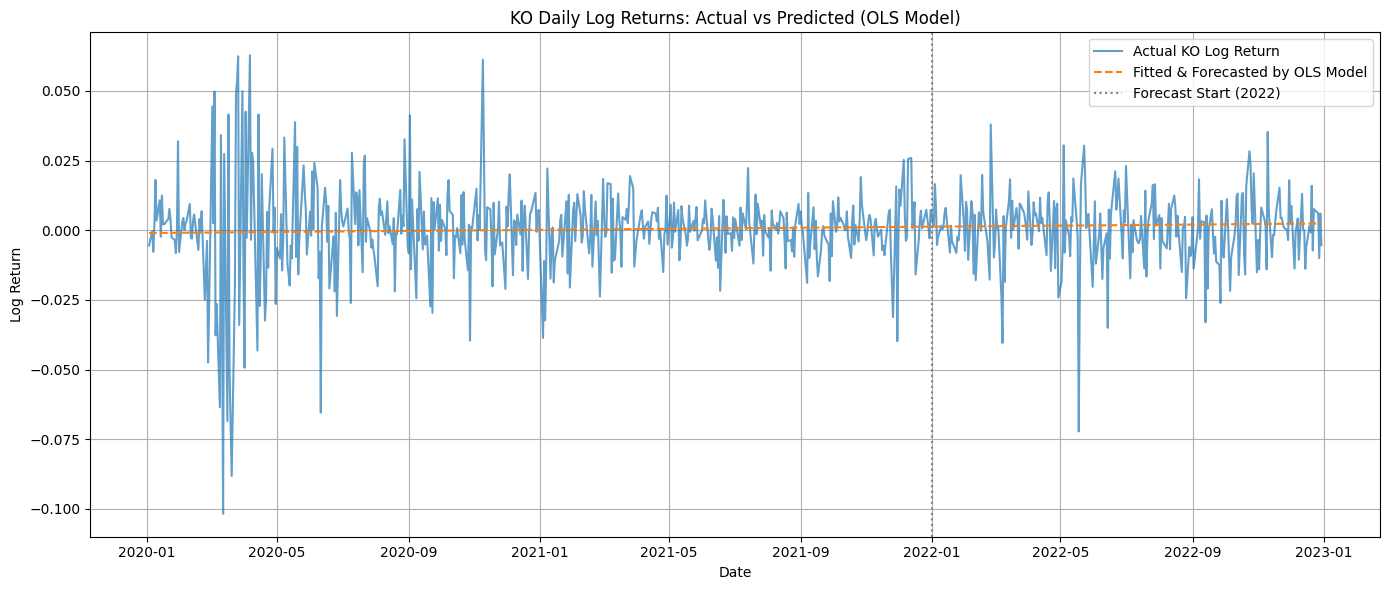

In [16]:
# --- 3. 测试集的解释变量（X） -----------------------------------------------
t_test = test_KO.index.map(pd.Timestamp.toordinal).to_numpy()
X_test = sm.add_constant(t_test)

y_test = test_KO.values

# --- 4. 模型预测 -------------------------------------------------------------
y_pred_test = model.predict(X_test)   # 对测试集进行预测
y_pred_train = model.predict(X_train) # 拟合训练集

# --- 5. 合并三年数据 ----------------------------------------------------------
# 构建完整的时间轴和真实 log return
all_dates = KO.loc["2020":"2022"].index
all_returns = KO.loc["2020":"2022", "log_return"]

# 构建预测值序列（仅预测训练期 + 测试期）
predicted = pd.Series(index=all_dates, dtype="float64")
predicted.loc[train_KO.index] = y_pred_train
predicted.loc[test_KO.index]  = y_pred_test

# --- 6. 可视化：真实 vs 拟合/预测 ---------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(all_returns.index, all_returns, label='Actual KO Log Return', alpha=0.7)
plt.plot(predicted.index, predicted, label='Fitted & Forecasted by OLS Model', linestyle='--')
plt.axvline(pd.Timestamp("2022-01-01"), color='gray', linestyle=':', label='Forecast Start (2022)')
plt.title("KO Daily Log Returns: Actual vs Predicted (OLS Model)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/KO(OLS).png", dpi=300, bbox_inches='tight')
plt.show()


In [17]:
s = model.get_robustcov_results(cov_type='HAC', maxlags=1)
print(s.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5620
Date:                Thu, 19 Jun 2025   Prob (F-statistic):              0.454
Time:                        18:55:34   Log-Likelihood:                 1339.8
No. Observations:                 504   AIC:                            -2676.
Df Residuals:                     502   BIC:                            -2667.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3085      3.080     -0.750      0.4

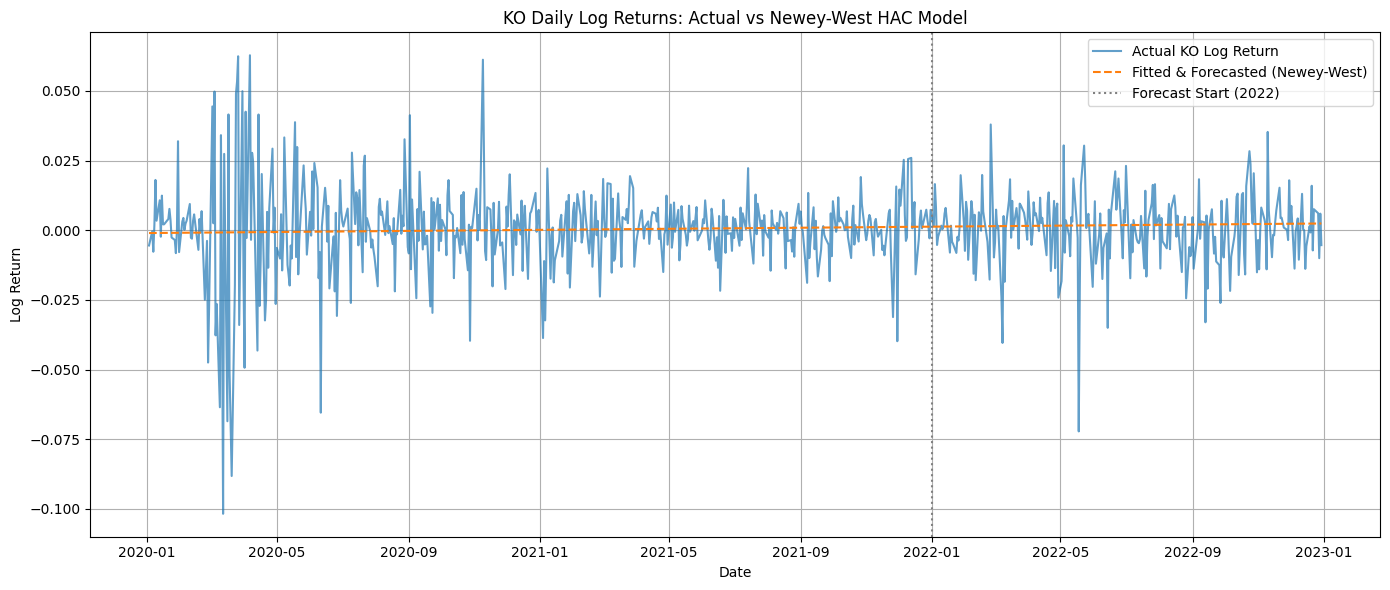

In [18]:
# --- 对训练集和测试集进行预测（与 OLS 相同） ------------------------------
y_pred_train_nw = s.predict(X_train)  # 拟合值
y_pred_test_nw  = s.predict(X_test)   # 预测值

# --- 构建完整预测序列（包括训练 + 测试） ----------------------------------
predicted_nw = pd.Series(index=all_dates, dtype="float64")
predicted_nw.loc[train_KO.index] = y_pred_train_nw
predicted_nw.loc[test_KO.index]  = y_pred_test_nw

# --- 画图：实际值 vs Newey-West 拟合 & 预测值 ------------------------------
plt.figure(figsize=(14, 6))
plt.plot(all_returns.index, all_returns, label='Actual KO Log Return', alpha=0.7)
plt.plot(predicted_nw.index, predicted_nw, label='Fitted & Forecasted (Newey-West)', linestyle='--')
plt.axvline(pd.Timestamp("2022-01-01"), color='gray', linestyle=':', label='Forecast Start (2022)')
plt.title("KO Daily Log Returns: Actual vs Newey-West HAC Model")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/KO(NW).png", dpi=300, bbox_inches='tight')
plt.show()


## 4 estimated regressions

### (1) Intercept, benchmark returns

In [19]:
train1 = pd.concat([
    train_KO.rename("KO_logRet"),
    train_SPY.rename("SPY_logRet")
], axis=1)

y1 = train1["KO_logRet"]
X1 = train1["SPY_logRet"]

X1c = (sm.add_constant(X1, has_constant='add')
          .rename(columns={"const": "Intercept"}))

# OLS
ols1 = sm.OLS(y1, X1c).fit()
print("=== OLS ===")
print(ols1.summary())

=== OLS ===
                            OLS Regression Results                            
Dep. Variable:              KO_logRet   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     669.3
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           2.05e-94
Time:                        18:55:34   Log-Likelihood:                 1552.9
No. Observations:                 504   AIC:                            -3102.
Df Residuals:                     502   BIC:                            -3093.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0005      0.000     -0.

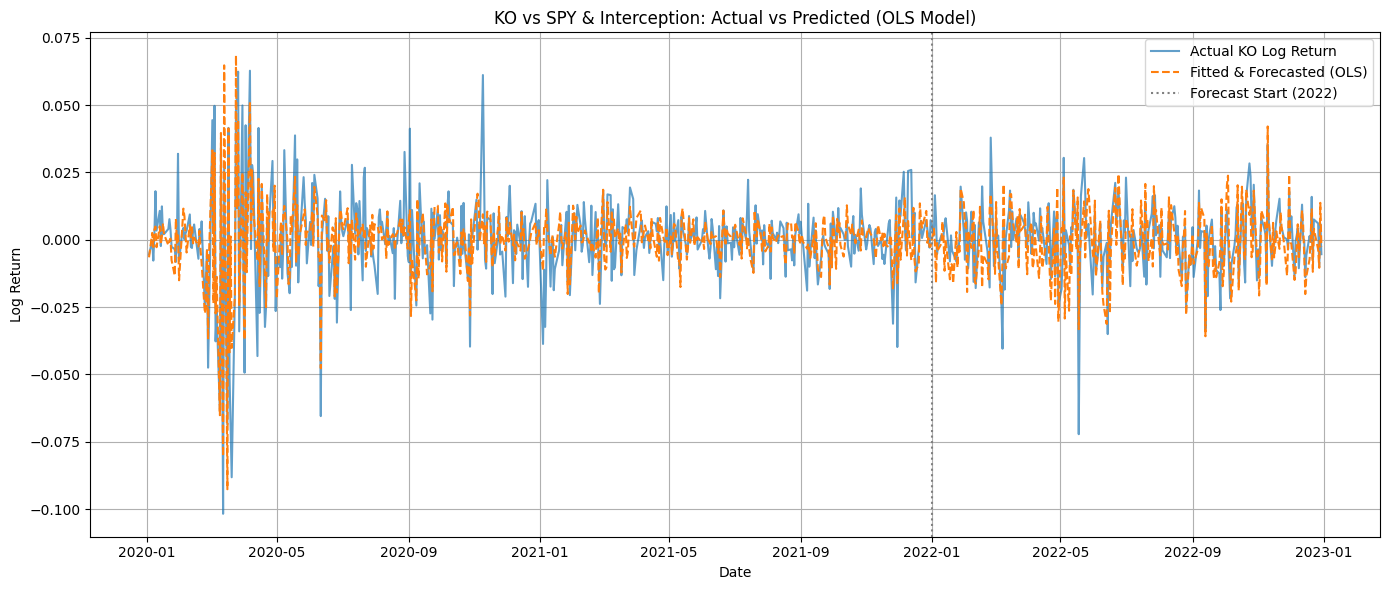

In [20]:
# --- 测试集拼接 --------------------------------------------------------
test1 = pd.concat([
    test_KO.rename("KO_logRet"),
    test_SPY.rename("SPY_logRet")
], axis=1).dropna()

y1_test = test1["KO_logRet"]
X1_test = test1["SPY_logRet"]
X1c_test = sm.add_constant(X1_test, has_constant='add')
X1c_test = X1c_test.rename(columns={"const": "Intercept"})

# --- 预测 --------------------------------------------------------------
y1_pred_train = ols1.predict(X1c)
y1_pred_test  = ols1.predict(X1c_test)

# --- 合并所有预测值 ---------------------------------------------------
predicted_capm = pd.Series(index=KO.loc["2020":"2022"].index, dtype="float64")
predicted_capm.loc[train1.index] = y1_pred_train
predicted_capm.loc[test1.index]  = y1_pred_test

# --- 实际值 -----------------------------------------------------------
actual = KO.loc["2020":"2022", "log_return"]

# --- 图像绘制 ----------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(actual.index, actual, label="Actual KO Log Return", alpha=0.7)
plt.plot(predicted_capm.index, predicted_capm, label="Fitted & Forecasted (OLS)", linestyle="--")
plt.axvline(pd.Timestamp("2022-01-01"), color='gray', linestyle=':', label='Forecast Start (2022)')
plt.title("KO vs SPY & Interception: Actual vs Predicted (OLS Model)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/KO_SPY(OLS).png", dpi=300, bbox_inches='tight')
plt.show()


In [21]:
# Newey-West (lag = 1)
s1 = ols1.get_robustcov_results(cov_type='HAC', maxlags=1)
print("\n=== Newey-West (lag = 1) ===")
print(s1.summary())



=== Newey-West (lag = 1) ===
                            OLS Regression Results                            
Dep. Variable:              KO_logRet   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     250.8
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           4.15e-46
Time:                        18:55:35   Log-Likelihood:                 1552.9
No. Observations:                 504   AIC:                            -3102.
Df Residuals:                     502   BIC:                            -3093.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0005 

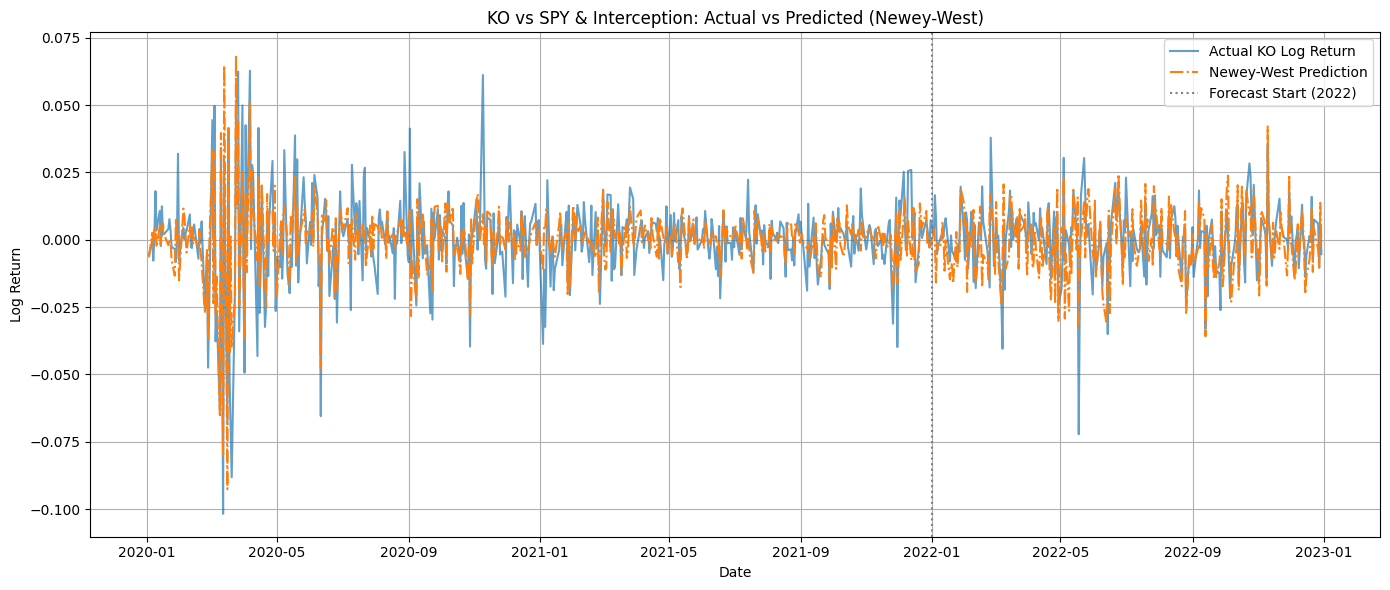

In [22]:
# --- 预测值（来自 OLS 和 Newey-West 修正模型） ---------------------
y_pred_train_ols = ols1.predict(X1c)
y_pred_test_ols  = ols1.predict(X1c_test)

y_pred_train_nw = s1.predict(X1c)
y_pred_test_nw  = s1.predict(X1c_test)

# --- 合并为完整序列（2020-2022） -------------------------------------
pred_ols_all = pd.Series(index=KO.loc["2020":"2022"].index, dtype="float64")
pred_nw_all  = pd.Series(index=KO.loc["2020":"2022"].index, dtype="float64")

pred_ols_all.loc[train1.index] = y_pred_train_ols
pred_ols_all.loc[test1.index]  = y_pred_test_ols

pred_nw_all.loc[train1.index] = y_pred_train_nw
pred_nw_all.loc[test1.index]  = y_pred_test_nw

actual = KO.loc["2020":"2022", "log_return"]

# --- 绘图 ------------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(actual.index, actual, label="Actual KO Log Return", alpha=0.7)
#plt.plot(pred_ols_all.index, pred_ols_all, label="OLS Prediction", linestyle="--")
plt.plot(pred_nw_all.index, pred_nw_all, label="Newey-West Prediction", linestyle="-.")
plt.axvline(pd.Timestamp("2022-01-01"), color='gray', linestyle=':', label="Forecast Start (2022)")
plt.title("KO vs SPY & Interception: Actual vs Predicted (Newey-West)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/KO_SPY(NW).png", dpi=300, bbox_inches='tight')
plt.show()


### (2) Intercept, CRSP returns

In [23]:
train2 = pd.concat([
    train_KO.rename("KO_logRet"),
    train_CRSP.rename("CRSP_logRet")
], axis=1).dropna()

y2  = train2["KO_logRet"]
X2  = train2["CRSP_logRet"]
X2c = (sm.add_constant(X2, has_constant='add')
          .rename(columns={"const": "Intercept"}))

ols2 = sm.OLS(y2, X2c).fit()
print("\n=== OLS ===")
print(ols2.summary())


=== OLS ===
                            OLS Regression Results                            
Dep. Variable:              KO_logRet   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     538.7
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           1.67e-81
Time:                        18:55:35   Log-Likelihood:                 1523.1
No. Observations:                 504   AIC:                            -3042.
Df Residuals:                     502   BIC:                            -3034.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0006      0.001    

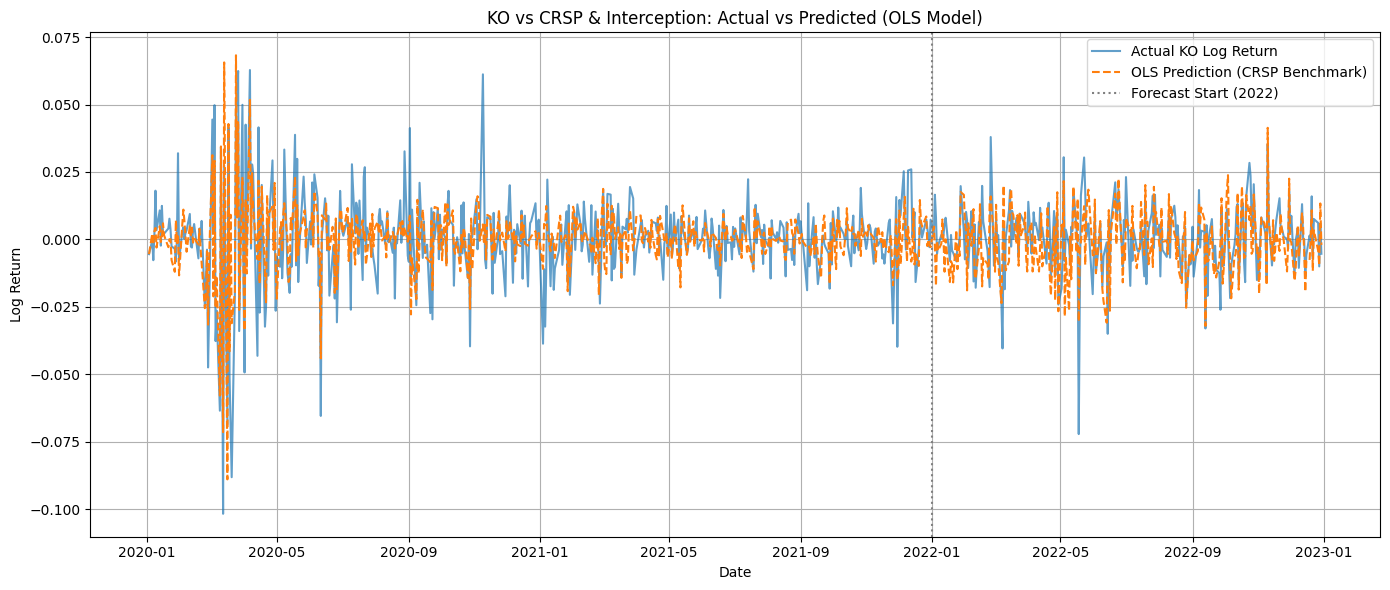

In [24]:
# --- 准备测试集 ------------------------------------------------------
test2 = pd.concat([
    test_KO.rename("KO_logRet"),
    test_CRSP.rename("CRSP_logRet")
], axis=1).dropna()

y2_test  = test2["KO_logRet"]
X2_test  = test2["CRSP_logRet"]
X2c_test = sm.add_constant(X2_test, has_constant='add')
X2c_test = X2c_test.rename(columns={"const": "Intercept"})

# --- 拟合 & 预测 -----------------------------------------------------
y2_pred_train = ols2.predict(X2c)
y2_pred_test  = ols2.predict(X2c_test)

# --- 合并为完整序列（2020–2022） -----------------------------------
pred_ols_crsp = pd.Series(index=KO.loc["2020":"2022"].index, dtype="float64")
pred_ols_crsp.loc[train2.index] = y2_pred_train
pred_ols_crsp.loc[test2.index]  = y2_pred_test

actual = KO.loc["2020":"2022", "log_return"]

# --- 绘图 ------------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(actual.index, actual, label="Actual KO Log Return", alpha=0.7)
plt.plot(pred_ols_crsp.index, pred_ols_crsp, label="OLS Prediction (CRSP Benchmark)", linestyle="--")
plt.axvline(pd.Timestamp("2022-01-01"), color='gray', linestyle=':', label="Forecast Start (2022)")
plt.title("KO vs CRSP & Interception: Actual vs Predicted (OLS Model)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/KO_CRSP(OLS).png", dpi=300, bbox_inches='tight')
plt.show()


In [25]:
# Newey-West (lag = 1)
s2 = ols2.get_robustcov_results(cov_type='HAC', maxlags=1)

print("\n=== Newey-West (lag = 1) ===")
print(s2.summary())


=== Newey-West (lag = 1) ===
                            OLS Regression Results                            
Dep. Variable:              KO_logRet   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     227.0
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           1.35e-42
Time:                        18:55:36   Log-Likelihood:                 1523.1
No. Observations:                 504   AIC:                            -3042.
Df Residuals:                     502   BIC:                            -3034.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.00

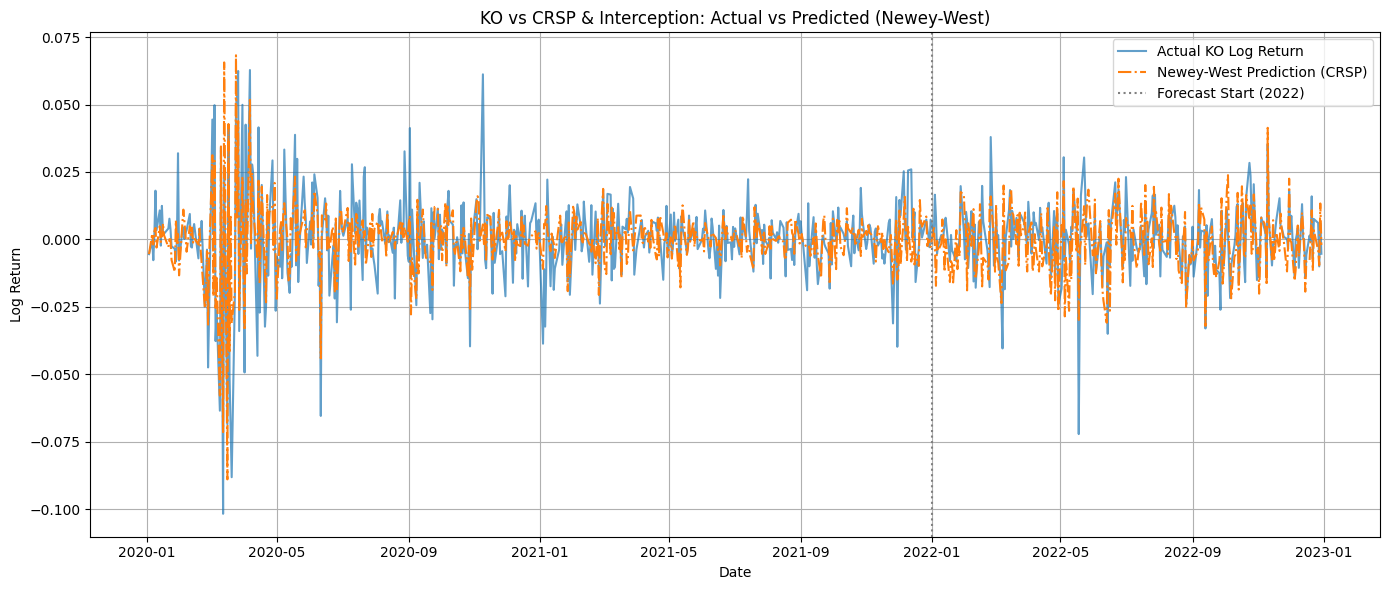

In [26]:
# --- 使用 OLS 和 Newey-West 模型分别预测 -----------------------------------
y2_pred_train_ols = ols2.predict(X2c)
y2_pred_test_ols  = ols2.predict(X2c_test)

y2_pred_train_nw = s2.predict(X2c)
y2_pred_test_nw  = s2.predict(X2c_test)

# --- 合并预测值为完整序列（2020–2022） -----------------------------------
pred_ols_crsp_all = pd.Series(index=KO.loc["2020":"2022"].index, dtype="float64")
pred_nw_crsp_all  = pd.Series(index=KO.loc["2020":"2022"].index, dtype="float64")

pred_ols_crsp_all.loc[train2.index] = y2_pred_train_ols
pred_ols_crsp_all.loc[test2.index]  = y2_pred_test_ols

pred_nw_crsp_all.loc[train2.index] = y2_pred_train_nw
pred_nw_crsp_all.loc[test2.index]  = y2_pred_test_nw

# --- 实际 log return ---------------------------------------------------
actual = KO.loc["2020":"2022", "log_return"]

# --- 绘图：OLS vs Newey-West vs Actual --------------------------------
plt.figure(figsize=(14, 6))
plt.plot(actual.index, actual, label="Actual KO Log Return", alpha=0.7)
#plt.plot(pred_ols_crsp_all.index, pred_ols_crsp_all, label="OLS Prediction (CRSP)", linestyle="--")
plt.plot(pred_nw_crsp_all.index, pred_nw_crsp_all, label="Newey-West Prediction (CRSP)", linestyle="-.")
plt.axvline(pd.Timestamp("2022-01-01"), color='gray', linestyle=':', label="Forecast Start (2022)")
plt.title("KO vs CRSP & Interception: Actual vs Predicted (Newey-West)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/KO_CRSP(NW).png", dpi=300, bbox_inches='tight')
plt.show()


### (3) Intercept, benchmark returns, X2 returns

In [27]:
train3 = pd.concat([
    train_KO.rename("KO_logRet"),
    train_SPY.rename("SPY_logRet"),
    train_GCF.rename("Gold_logRet")
], axis=1)

y3 = train3["KO_logRet"]
X3 = train3[["SPY_logRet", "Gold_logRet"]]

X3c = (sm.add_constant(X3, has_constant='add')
          .rename(columns={"const": "Intercept"}))

# OLS
ols3 = sm.OLS(y3, X3c).fit()
print("=== OLS ===")
print(ols3.summary())

=== OLS ===
                            OLS Regression Results                            
Dep. Variable:              KO_logRet   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     334.3
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           5.85e-93
Time:                        18:55:36   Log-Likelihood:                 1553.0
No. Observations:                 504   AIC:                            -3100.
Df Residuals:                     501   BIC:                            -3087.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0005      0.000     

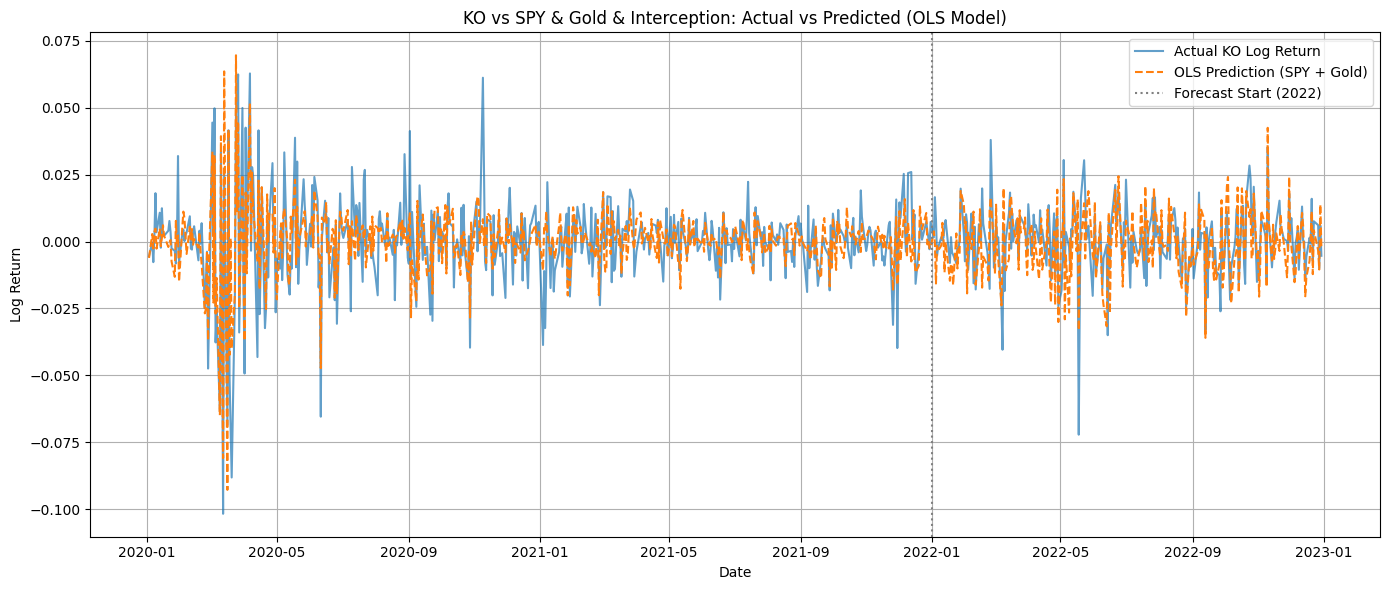

In [28]:
# --- 测试集准备 ---------------------------------------------------------
test3 = pd.concat([
    test_KO.rename("KO_logRet"),
    test_SPY.rename("SPY_logRet"),
    test_GCF.rename("Gold_logRet")
], axis=1).dropna()

y3_test = test3["KO_logRet"]
X3_test = test3[["SPY_logRet", "Gold_logRet"]]
X3c_test = sm.add_constant(X3_test, has_constant='add')
X3c_test = X3c_test.rename(columns={"const": "Intercept"})

# --- 预测值 -------------------------------------------------------------
y3_pred_train = ols3.predict(X3c)
y3_pred_test  = ols3.predict(X3c_test)

# --- 拼接完整序列 ------------------------------------------------------
pred_ols_multi = pd.Series(index=KO.loc["2020":"2022"].index, dtype="float64")
pred_ols_multi.loc[train3.index] = y3_pred_train
pred_ols_multi.loc[test3.index]  = y3_pred_test

actual = KO.loc["2020":"2022", "log_return"]

# --- 图像绘制 -----------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(actual.index, actual, label="Actual KO Log Return", alpha=0.7)
plt.plot(pred_ols_multi.index, pred_ols_multi, label="OLS Prediction (SPY + Gold)", linestyle="--")
plt.axvline(pd.Timestamp("2022-01-01"), color='gray', linestyle=':', label="Forecast Start (2022)")
plt.title("KO vs SPY & Gold & Interception: Actual vs Predicted (OLS Model)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/KO_SPY_X2(OLS).png", dpi=300, bbox_inches='tight')
plt.show()


In [29]:
# Newey-West (lag = 1)
s3 = ols3.get_robustcov_results(cov_type='HAC', maxlags=1)
print("\n=== Newey-West (lag = 1) ===")
print(s3.summary())


=== Newey-West (lag = 1) ===
                            OLS Regression Results                            
Dep. Variable:              KO_logRet   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     132.2
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           7.70e-47
Time:                        18:55:37   Log-Likelihood:                 1553.0
No. Observations:                 504   AIC:                            -3100.
Df Residuals:                     501   BIC:                            -3087.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.00

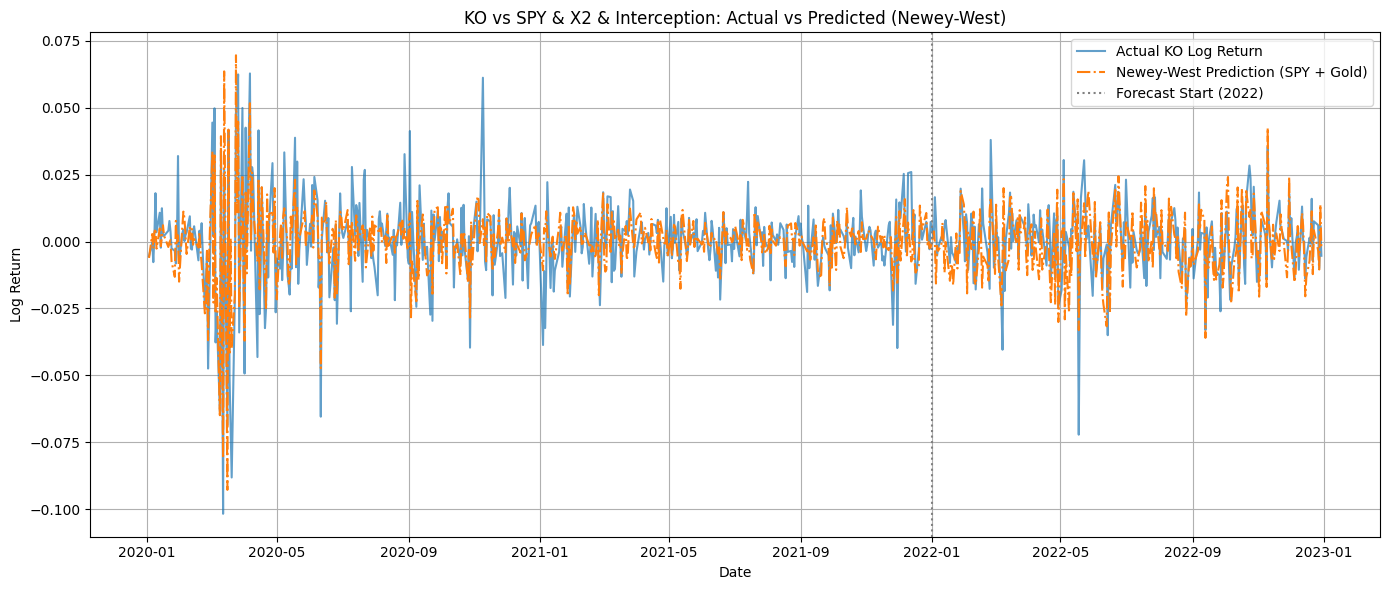

In [30]:
y3_pred_train_nw = s3.predict(X3c)
y3_pred_test_nw  = s3.predict(X3c_test)

pred_nw_multi = pd.Series(index=KO.loc["2020":"2022"].index, dtype="float64")
pred_nw_multi.loc[train3.index] = y3_pred_train_nw
pred_nw_multi.loc[test3.index]  = y3_pred_test_nw

# --- 绘图 ---------------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(actual.index, actual, label="Actual KO Log Return", alpha=0.7)
#plt.plot(pred_ols_multi.index, pred_ols_multi, label="OLS Prediction (SPY + Gold)", linestyle="--")
plt.plot(pred_nw_multi.index, pred_nw_multi, label="Newey-West Prediction (SPY + Gold)", linestyle="-.")
plt.axvline(pd.Timestamp("2022-01-01"), color='gray', linestyle=':', label="Forecast Start (2022)")
plt.title("KO vs SPY & X2 & Interception: Actual vs Predicted (Newey-West)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/KO_SPY&X2(NW).png", dpi=300, bbox_inches='tight')
plt.show()

### (4) Intercept, CRSP returns, X2 returns

In [31]:
train4 = pd.concat([
    train_KO.rename("KO_logRet"),
    train_CRSP.rename("CRSP_logRet"),
    train_GCF.rename("Gold_logRet")
], axis=1).dropna()

y4  = train4["KO_logRet"]
X4  = train4[["CRSP_logRet", "Gold_logRet"]]
X4c = (sm.add_constant(X4, has_constant='add')
          .rename(columns={"const": "Intercept"}))

ols4 = sm.OLS(y4, X4c).fit()
print("\n=== OLS ===")
print(ols4.summary())


=== OLS ===
                            OLS Regression Results                            
Dep. Variable:              KO_logRet   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     269.0
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           4.51e-80
Time:                        18:55:37   Log-Likelihood:                 1523.2
No. Observations:                 504   AIC:                            -3040.
Df Residuals:                     501   BIC:                            -3028.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0006      0.001    

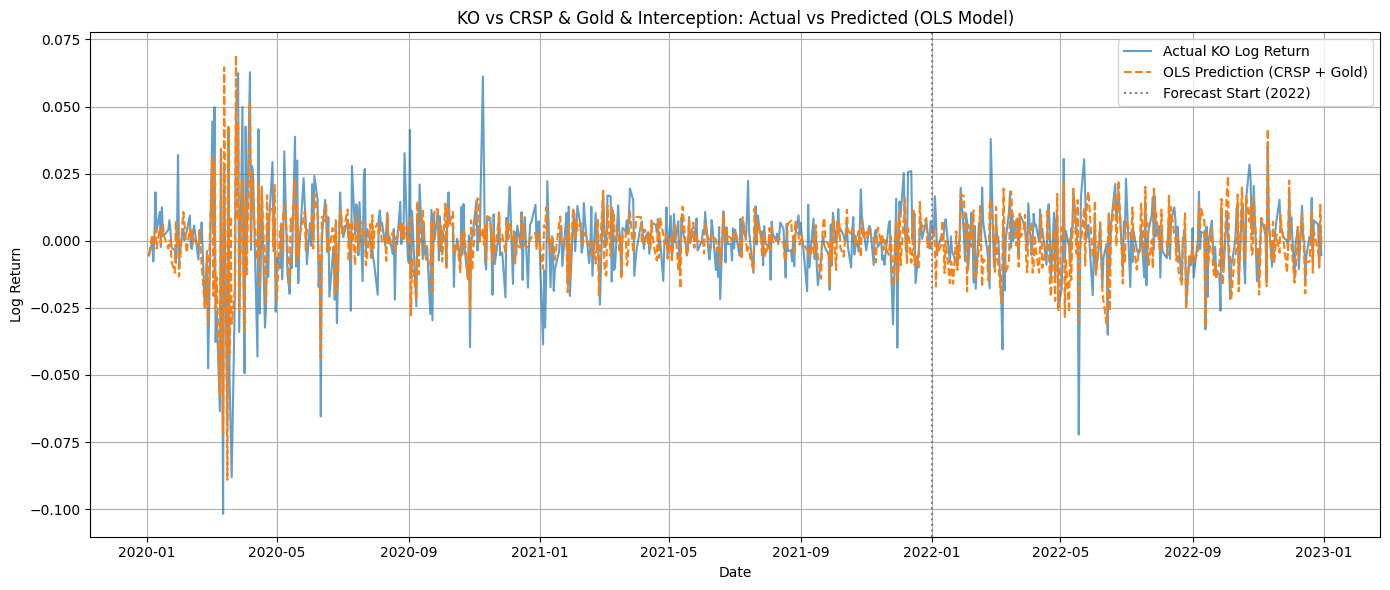

In [32]:
# --- 测试集准备 -------------------------------------------------------
test4 = pd.concat([
    test_KO.rename("KO_logRet"),
    test_CRSP.rename("CRSP_logRet"),
    test_GCF.rename("Gold_logRet")
], axis=1).dropna()

y4_test  = test4["KO_logRet"]
X4_test  = test4[["CRSP_logRet", "Gold_logRet"]]
X4c_test = sm.add_constant(X4_test, has_constant='add')
X4c_test = X4c_test.rename(columns={"const": "Intercept"})

# --- OLS 预测 ---------------------------------------------------------
y4_pred_train = ols4.predict(X4c)
y4_pred_test  = ols4.predict(X4c_test)

pred_ols_4 = pd.Series(index=KO.loc["2020":"2022"].index, dtype="float64")
pred_ols_4.loc[train4.index] = y4_pred_train
pred_ols_4.loc[test4.index]  = y4_pred_test

actual = KO.loc["2020":"2022", "log_return"]

# --- 图：OLS 预测值 ---------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(actual.index, actual, label="Actual KO Log Return", alpha=0.7)
plt.plot(pred_ols_4.index, pred_ols_4, label="OLS Prediction (CRSP + Gold)", linestyle="--")
plt.axvline(pd.Timestamp("2022-01-01"), color='gray', linestyle=':', label="Forecast Start (2022)")
plt.title("KO vs CRSP & Gold & Interception: Actual vs Predicted (OLS Model)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/KO_CRSP_X2(OLS).png", dpi=300, bbox_inches='tight')
plt.show()


In [33]:
s4 = ols4.get_robustcov_results(cov_type="HAC", maxlags=1)
print("\n=== Newey-West (lag = 1) ===")
print(s4.summary())


=== Newey-West (lag = 1) ===
                            OLS Regression Results                            
Dep. Variable:              KO_logRet   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     117.3
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           1.60e-42
Time:                        18:55:37   Log-Likelihood:                 1523.2
No. Observations:                 504   AIC:                            -3040.
Df Residuals:                     501   BIC:                            -3028.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.00

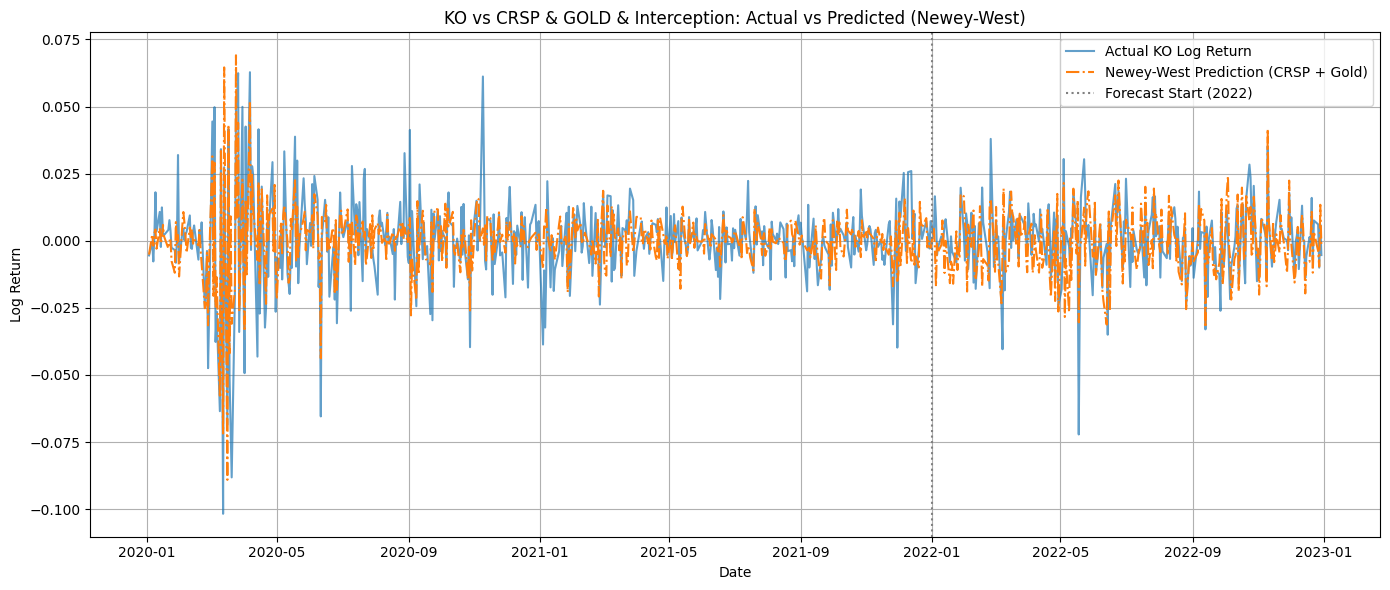

In [34]:
y4_pred_train_nw = s4.predict(X4c)
y4_pred_test_nw  = s4.predict(X4c_test)

pred_nw_4 = pd.Series(index=KO.loc["2020":"2022"].index, dtype="float64")
pred_nw_4.loc[train4.index] = y4_pred_train_nw
pred_nw_4.loc[test4.index]  = y4_pred_test_nw

# --- 图：OLS vs Newey-West --------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(actual.index, actual, label="Actual KO Log Return", alpha=0.7)
#plt.plot(pred_ols_4.index, pred_ols_4, label="OLS Prediction (CRSP + Gold)", linestyle="--")
plt.plot(pred_nw_4.index, pred_nw_4, label="Newey-West Prediction (CRSP + Gold)", linestyle="-.")
plt.axvline(pd.Timestamp("2022-01-01"), color='gray', linestyle=':', label="Forecast Start (2022)")
plt.title("KO vs CRSP & GOLD & Interception: Actual vs Predicted (Newey-West)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/KO_CRSP&X2(NW).png", dpi=300, bbox_inches='tight')
plt.show()